# Starbucks Capstone Challenge: Using Starbucks app user data to predict effective offers

## Project Overview

In my capstone project, I aim to answer 2 main business questions:
1. What are the main drivers of an effective offer on the Starbucks app? 
2. Could the data provided, namely offer characteristics and user demographics, predict whether a user would take up an offer? 

This capstone project is using data provided by Udacity as part of the Data Scientist Nanodegree course. It contains simulated data that mimics customer behavior on the Starbucks rewards mobile app.

The provided background information on the mobile app is that once every few days, Starbucks sends out an offer to users of the mobile app. Some users might not receive any offer during certain weeks, and not all users receive the same offer.

## Problem Statement

As stated above, the problem statement I am aiming to answer are to (1) discover the main drivers of offer effectiveness, and (2) explore if we can predict whether a user would take up an offer.

The data provided consists of 3 datasets:
- Offer portfolio, which consists of the attributes of each offer
- Demographic data for each customer
- Transactional records of events occurring on the app

Using the data provided, I answer the above two questions using 3 classification supervised machine learning models, feeding in the data from three different offer types. 

I use the model to uncover the feature importances to identify the drivers of offer effectiveness, while exploring if the model itself could be used to predict if a user would take up an offer. 

Lastly, I also explore the characteristics of users who do or do not take up an offer.

My project aims to answer the two questions above, but I also ended up adding 2 additional models as points of exploration - the first assessing whether an all-in-one model could be used in place of 3 different models, with the offer types functioning as a categorical variable. Secondly, I also build a regression model to see if we could predict the amount a user would spend, given that the offer is effectively influencing them.

### Imports & load in data

In [1]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from time import time
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

## Data Exploration

### a. Offer portfolio data

According to the information provided by Udacity, the schema is as follows:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

Moreover, some further information given about the offers is that there are 3 different offer types:
- BOGO - buy one get one free
- Discount - discount with purchase
- Informational - provides information about products

Thus, the schema is pretty straightforward, as it contains the attributes of 3 different offer types. While the duration was not explained I assumed from context that it is in terms of number of days.

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


The `channels` column consists of nested lists. Hence, I note that I will have to expand the column later during preprocessing to become categorical variables in my dataset. I also note that the scale of each are different, for example the `difficulty` is in terms of dollars while the `duration` is in terms of days. Hence, some feature scaling will need to be done.

In [3]:
#check for null values
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

Good news is that there are no missing values in this dataset, hence we won't have to impute or make any decisions to remove them during the preprocessing stage.

In [4]:
#check no. of unique offers
portfolio.id.nunique()

10

In [5]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

There are 10 unique offer ids we will have to take note of, with 4 each of bogo and discount types, while 2 informational types.

### b. Demographic data

Demographic data for customers is provided in the `profile` dataset. The schema and variables are as follows: 

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

It is also relatively straightforward, as it contains the demographic profile on the customer.

In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


From the first 5 lines we can already see some null values in `gender` and `income`, while the `age` column contains some values that don't make sense (e.g. 118).

In [7]:
#check for null values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

As suspected, the `gender` and `income` have null values. Some good news is that whichever values are null in `gender` are also null in `income`. 

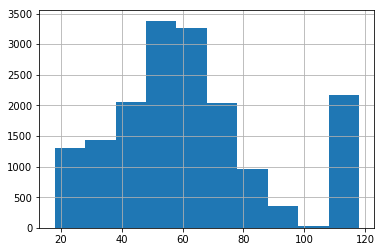

In [8]:
#check distribution of age column
profile.age.hist()

We can see above that the `age = 118` value does not make sense there as it is clearly out of the normal distribution.

In [9]:
#check count of age=118 value and corresponding gender and income columns
print(profile[profile['age']==118].count())
profile[['gender','income','age']][profile['age']==118].head()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64


,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


As we can see above, the `age=118` column corresponds with the null `gender` and `income` columns. Thus, we can actually drop them during preprocessing if they do not take too large a proportion of our data.

In [10]:
#check how many unique people are in dataset
profile['id'].nunique()

17000

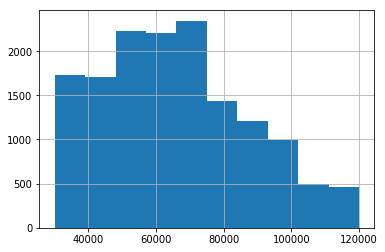

In [11]:
#check distributions of income
profile.income.hist()

Last but not least, the `became_member_on` column has some potential to be feature engineered to get the tenure of membership in days. This feature might have some influence on whether an offer is effective or not.

In [12]:
profile.became_member_on.head()

0    20170212
1    20170715
2    20180712
3    20170509
4    20170804
Name: became_member_on, dtype: int64

### c. Transactional records

The schema for the transactional data is as follows:

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [13]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [14]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

This data looks a bit more tricky, as it is ordered by time and has an event and value. In particular, the `value` column will have to be preprocessed depending on the event.

In [15]:
#check number of unique people represented
transcript['person'].nunique()

17000

It looks as though the number of people in transcript are the same as the number of people in the Demographics Data, so that is good news. But a lot of preprocessing will need to be done in order to extract meaningful insights out of this dataset.

In [16]:
#check for null values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

There are no null values in this data.

In order to extract insights from the value column, I will have to expand the values into individual columns depending on the event.

In [17]:
transcript=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


It appears as though the `offer id` column ended up being duplicates so we have to clean it up further to ensure there is only one `offer id` column.

In [18]:
#create new column to ensure only one offer_id column
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

#drop unnecessary offer_id columns
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)

#rename offer_id column
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [19]:
transcript.head()

,event,person,time,value,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


Now the additional transcript columns can be used for further exploration.

## Defining approach for preprocessing data for the model

Before I proceeded to preprocess the data for the model, I first revisited my objective. Having done a preliminary exploration of the data, I had to reassess how I would clean and prepare the data for the models I intended to build.

In order to identify the main drivers of an effective offer, I have to first define what an 'effective' offer is within the Starbucks app. Thus, I did some further exploration on the datasets and how all three would interact.

First, I had to explore what kind of events are within each offer type.

In [20]:
#rename column
portfolio.rename(columns={'id':'offer_id'},inplace=True)

#join transcript with offer type
transcript=transcript.merge(portfolio,how='left',on='offer_id')

In [21]:
transcript.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

We know that there are 4 types of events: `offer completed`, `offer received`, `offer viewed` and `transaction`. But our data shows that we do not have any offer_id associated with `transactions`, because they are not recorded in the transcript event data. Thus, the first objective in data preprocessing is to define a methodology to assign offer_ids to specific transactions.

Moreover, we also know that BOGO and discount offers have an `offer completed` event when offers are completed. However, informational offers do not have this event associated with it. Thus, we also specify the approach to define an effective offer as follows:

For a BOGO and discount offer, an effective offer would be defined if the following events were recorded in the right sequence in time:

`offer received` -> `offer viewed` -> `transaction` -> `offer completed`

Meanwhile, for an informational offer, since there `offer completed` event associated with it, I will have to define transactions as a conversion to effective offer:

`offer received` -> `offer viewed` -> `transaction`

## Data Preprocessing

### a. Assigning offer ids to transactions

After defining the approach above, we now have to explore methods to assign offer_ids to specific transactions. Among the 
considerations is to define the following main groups of customers:

**1. People who are influenced and successfully convert - effective offers:**

    - `offer received` -> `offer viewed` -> `transaction` -> `offer completed` (BOGO/discount offers)
    - `offer received` -> `offer viewed` -> `transaction` (informational offers - must be within validity period of offer)

**2. People who received and viewed an offer but did not successfully convert - ineffective offers:**

    - `offer received` -> `offer viewed`
    
**3. People who purchase/complete offers regardless of awareness of any offers:**
    
    - `transaction`
    - `offer received` -> `transaction` -> `offer completed` -> `offer viewed`
    - `transaction` -> `offer received` -> `offer completed` -> `offer viewed`
    - `offer received` -> `transaction` -> `offer viewed` -> `offer completed`
    - `offer received` -> `transaction` (informational offers)
    - `offer received` -> `transaction` -> `offer viewed` (informational offers)

**4. People who received offers but no action taken:**

    - `offer received`
    
For people in group 2, I would need to check if there are events where there is an `offer received` and `offer viewed` event, but no conversion event, i.e. `offer completed` or `transaction` - these are cases of ineffective offers.

I would have to separate out the people in group 2 from people in group 4, as people in group 2 may have viewed an offer but did not take any action, whereas people in group 4 did not even have an `offer viewed` event.

Separating the conversions for effective offers (group 1) and people who purchase/complete offers regardless of awareness of any offers (group 3) is particularly tricky. 
For people in group 3, a conversion is invalid (i.e., not a successful conversion from an offer) if an `offer completed` or `transaction` occurs before an `offer viewed`. There also may be scenarios where an `offer completed` occurs after the offer is viewed, but a transaction was done prior to the offer being viewed. In this instance, the offer may have been completed, but it is also not a valid conversion.  

**Defining the target variable `effective offer`:**

After defining these conditions, we have to decide what the target variable will be.

We know that group 1 customers will be our target variable `effective_offer=1`, but there are many ineffective offer definitions for groups 2-4. 

So what would we define as an ineffective offer? As already stated above, group 2 would be within our definition of an ineffective offer; where a user is aware of an offer, but the offer is ineffective as it does not convert the user into a customer. So group 2 can be defined as our target variable `effective_offer=0`.

What about group 3 and group 4? Group 3 consists of users who may have received offers but would have purchased regardless. From the business point of view, we would not want to be sending them any offers. 

Meanwhile, group 4 users would be considered low priority customers, as they do not do any action, regardless of whether they receive offers or not.  

So, we can deprioritise group 3 and group 4 users from our model. It would still be worth doing some exploratory analysis onto group 3 and 4, just to explore on their demographics.

The conditions above are the basis of which I can assign the offer id that 'influences' a transaction by ensuring that the transaction occurs after an `offer viewed` event. 

After sorting the transcript dataset by person and time to ensure that each event for each person occurs in sequence, I can filter the dataset by events `offer viewed` and `transaction` to ensure that it only contains those events in order. 

Then, I can use pandas' `ffill()` method to fill every transaction with the offer_id of the viewed offer, only if it occurs before the transaction.

In [22]:
#define dropcolumns function as I will be doing this many times
def drop_cols(drop_cols,df,inplace=False):
    '''
    inputs:
    - drop_cols: list or string of column name to be dropped
    - df: dataframe from which column should be dropped
    - inplace: specify whether columns are dropped in place or not
    
    outputs:
    - Returns dataframe with dropped columns.
       
    '''
    df=df.drop(columns=drop_cols,axis=1,inplace=inplace)
    return df

In [23]:
#drop unnecessary columns to clean dataset
transcript=drop_cols(['reward_x','reward_y'],transcript)
#sort events by person and time
transcript=transcript.sort_values(['person','time'])

In [24]:
#filter dataset for transactions that occur after an offer is viewed, forward fill offer ids by person
offers_view_transacted=transcript[['time','offer_id','person','event']][(transcript['event']=='transaction') | (transcript['event']=='offer viewed')].groupby(['person','offer_id']).ffill()
offers_view_transacted['offer_id']=offers_view_transacted['offer_id'].ffill()

Since the above temporary dataset is just a subset of the `transcript` dataset, I can create a new dataset with the filled in offer ids for transactions.

In [25]:
transcript=transcript.merge(offers_view_transacted,how='left',on=['person','time','event'])

In [26]:
#clean up dataset to unify multiple offer_id columns into one column
transcript['offer_id']=np.where(transcript['offer_id_x'].isnull(),transcript['offer_id_y'],transcript['offer_id_x'])

drop_cols(['offer_id_x','offer_id_y'],transcript,inplace=True);

In [27]:
#merge portfolio dataset again to get offer data for the transaction events
transcript=transcript.merge(portfolio,how='left',on='offer_id')
transcript['duration']=np.where(transcript['duration_x'].isnull(),transcript['duration_y'],transcript['duration_x'])
drop_cols(['duration_x','offer_type_x','difficulty_x','channels_x','duration_y'],transcript,inplace=True);
transcript.rename(columns={'channels_y':'channels','reward_y':'reward','difficulty_y':'difficulty','offer_type_y':'offer_type'},inplace=True)

In [28]:
transcript.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0


### b. Flagging transactions and offers completed after offers viewed

The next important step for preparing our data for modeling and analysis is to identify a completed offer and transactions occurring after an offer is viewed. 

Once we have assigned a transaction occurring after an offer is viewed, I can use that information to subset my data according to the groups defined above, and analyse within each group.

Using our dataset with the offer_ids populated for `transaction` events, we can  flag the converted transactions and completed offers. We have to first ensure that the offer id of the previous event is the same one. Since we have tagged the offer id for all viewed, transactions and completed offers, we can use the `offer_id` field to ensure that the previous offer consists of those events. 

This means that as long as the events `offer viewed`,`transaction`, and `offer completed` occur in the same event space and are in the corrrect sequence of time, we can be assured that it is a transaction and/or completed offer occurring only after an offer is viewed. 

To do this, I created a new column to flag the previous offer id using pandas' `shift` function.

In [29]:
#get sample space of events consisting of offer viewed, transactions and offer completed
offers_viewed_transactions_completed=transcript[(transcript['event']=='offer viewed') | (transcript['event']=='transaction') | (transcript['event']=='offer completed')].copy()

In [30]:
#add extra column to flag the previous offer id
offers_viewed_transactions_completed['offer_id_previous'] = offers_viewed_transactions_completed.groupby(['person','offer_id'])['offer_id'].shift()

In [31]:
#flag a completed transaction/offer completed as long as the previous offer id consists of events in the same sample space
offers_viewed_transactions_completed['valid_completed']=np.where(offers_viewed_transactions_completed['offer_id_previous']==offers_viewed_transactions_completed['offer_id'],1,0)

Since our dataset `offers_viewed_transactions_completed` consists of all other possible events, all we need to do is to append the all `offers received` events in the `transactions_clean` dataset to ensure we have our complete dataset again.

In [32]:
#get only offer received events
offers_received=transcript[transcript['event']=='offer received'].copy()

#ensure all columns are the same between datasets to be appended
offers_received['offer_id_previous']=np.nan
offers_received['valid_completed']=np.nan

#append datasets to complete dataset of transactions
transcript=offers_received.append(offers_viewed_transactions_completed)

#sort values
transcript=transcript.sort_values(['person','time'])

Having assigned offer_ids for transactions for which an `offer viewed` event occurred prior, we can now revisit the four customer groups of unique person-offer_id pairs we are trying to analyse.

Since we consider the conversion events of depending on offer type differently, we have to first separate the transcript into 3 different offer types, in order to accommodate for the different treatment in assigning the target variable.

In [33]:
#define function to split into 3 offer types
def split(offer_type,grp_df):
    '''
    Splits dataframe to groups of specified offer type.
    
    inputs:
    - offer_type: specify offer type name in string format 
    - grp_df: original transcript dataframe to split on offer type
    
    outputs:
    - Returns dataframe containing data of just offer type.
       
    '''
    df=grp_df[grp_df['offer_type']==offer_type].copy()
    return df

#split transcript into 3 different offer types
transcript_bogo=split('bogo',transcript)
transcript_discount=split('discount',transcript)
transcript_info=split('informational',transcript)

Within each offer type, we can already successfully separate every unique person-offer_id in group 1 from the others using our `valid_completed` column. Since we have flagged all conversion events (`transaction` or `offer completed` event depending on offer type) occurring after an `offer viewed` event, we can be assured that whichever conversion events are flagged with `valid_completed=1` are at least within the first group (People who are influenced and successfully convert - effective offers).

For BOGO and discount offers, we will only consider `offer completed` events as the conversion events, while we can consider `transaction` event as the conversion event for the informational offers. 

In [34]:
#since will do this for both BOGO and discount, define function for repeated operation
def grp1(df):
    '''
    Subsets dataframe to just group 1 members.
    
    inputs:
    - df: original transcript dataframe 

    outputs:
    - Returns dataframe containing transcript data of just group 1 users.
       
    '''
    grp1=df[['person','offer_id']][(df['valid_completed']==1) & (df['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()
    return grp1

grp1_bogo=grp1(transcript_bogo)
grp1_discount=grp1(transcript_discount)

Meanwhile, for informational offers we will define group 1 later as there is an additional consideration we need to take into account for transactions - they need to occur within the validity period of an informational offer for us to consider them as effective offers.

Now, we can look into separating group 2 and group 4 unique person-offer_ids for BOGO and discount offers as we just need to look at the subset of people with `offer received`, `offer viewed`, but no conversion events. We can also assume that every person who views an offer would have had an `offer received` event prior, so we can just take the whole group of people who received an offer and subset them later.

In [35]:
#again, we define a function as we will repeat this for 2 datasets - BOGO & discount
def no_conv(df):
    
    '''
    Takes in transcript dataframe of single offer type to check for people who converted vs people with just offer received events. 
    
    inputs:
    - df: original transcript dataframe of specific offer type 
    
    outputs:
    - Returns dataframe containing unqiue person-offer_id pairs with conversion events and offers received events, with indicator of each.
    
    Note: left_only indicator is just the offers received events, right_only is just conversion events
       
    '''
    
    #subset offer ids that have transactions or conversions by person and offer_id
    conversion_ids=df[['person','offer_id']][(df['event']=='transaction') | (df['event']=='offer completed') ].groupby(['person','offer_id']).count().reset_index()

    #check for unique person-offer_id pairs that consist of offers received 
    offers_received_only=df[['person','offer_id']][df['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()

    #create merged dataset to diffrentiate groups
    check_merge=conversion_ids.merge(offers_received_only,how='right',on=['person','offer_id'],indicator=True)
    return check_merge

#check how many are in either group
check_merge_bogo=no_conv(transcript_bogo)
print('For BOGO offers:')
print(check_merge_bogo.groupby(['_merge']).count())

check_merge_discount=no_conv(transcript_discount)
print('For Discount offers:')
print(check_merge_discount.groupby(['_merge']).count())

For BOGO offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    4729      4729
both         20592     20592
For Discount offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    6415      6415
both         18901     18901


We can see that there are definitely a fair number of unique person-offer_id pairs that have `offer received` events, but no conversion events. These would be considered offers in group 2 and 4 within each offer type, according to our definition above. 

People with an `offer viewed` event in this subset are definitely in group 2, as we can assume everyone with an `offer viewed` event has an `offer received` event prior.

In [36]:
#define group 2 & 4 function as will repeat this for BOGO and discount offers
def grp_2_4(df):
    
    '''
    Takes in output dataframe from no_conv function to split into group 2 and 4 customers.
    
    inputs:
    - df: output dataframe from no_conv function
    
    outputs:
    - Returns 2 dataframes containing unique person-offer_id pairs with dataframe containing only group2 customers first, followed by dataframe containing only group 4 customers. 
       
    '''
    
    #subset to check group 2 and 4
    grp_2_4=df[df['_merge']=='right_only']

    #remerge with transcript to get events
    grp_2_4=grp_2_4.merge(transcript,how='left',on=['person','offer_id'])

    #within this subset, separate people with offer viewed event, and people with offer received but no offer viewed
    grp2=grp_2_4[['person','offer_id']][grp_2_4['event']=='offer viewed'].groupby(['person','offer_id']).count().reset_index()
    
    #remerge with full dataset and get remaining to get grp4
    drop_cols('_merge',grp_2_4,inplace=True)
    grp4=grp_2_4.merge(grp2[['person','offer_id']],how='left',indicator=True)
    grp4=grp4[grp4['_merge']=='left_only'].copy()
    
    return grp2,grp4

grp2_bogo,grp4_bogo=grp_2_4(check_merge_bogo)
grp2_discount,grp4_discount=grp_2_4(check_merge_discount)

Group 3 people are everyone in the converted ids who do not have an offer viewed prior - hence, they would be people with conversion events but no `offer viewed` event prior. For BOGO and discount offers, they would be people with `offer completed` events that have `valid_completed != 1`.

In [37]:
def grp3(df):
    '''
    Takes in transcript dataframe of single offer type to check for people who converted vs people with just offer received events. 
    
    inputs:
    - df: original transcript dataframe of specific offer type 
    
    outputs:
    - Returns dataframe containing unqiue person-offer_id pairs with conversion events and offers received events, with indicator of each.
       
    '''
    
    #check all conversion events with invalid conversions
    grp3=df[['person','offer_id']][(df['event']=='offer completed') & (df['valid_completed']!=1)].groupby(['person','offer_id']).count().reset_index()
    return grp3

grp3_bogo=grp3(transcript_bogo)
grp3_discount=grp3(transcript_discount)

Now we have split our data into 4 different customer groups for the BOGO and discount offers. Next, we have to consider the effective and ineffective offers depending on the group type. As already elaborated above, any unique person-offer_id belonging to group 1 can be considered in our target variable `effective_offer=1` group.

Meanwhile, group 2 is in our target variable `effective_offer=0` group. For customers in groups 3 and 4, I deprioritise them for model implementation, but will be doing some exploratory analysis on them later.

In [38]:
def offers(grp1,grp2):
    '''
    inputs:
    - grp1: dataframe containing group1 customer data 
    - grp2: dataframe containing group2 customer data
    
    outputs:
    - Returns dataframe with labeled effective offer column
    '''
    #assign effective offer flag column
    grp1['effective_offer']=1
    grp2['effective_offer']=0

    #append datasets together
    offers=grp1.append(grp2,sort=False)
    return offers

offers_bogo=offers(grp1_bogo,grp2_bogo)
offers_discount=offers(grp1_discount,grp2_discount)

Now we have successfully prepared the target variables for our BOGO and discount datasets. 

Meanwhile, for informational offers in particular, before we can tag the effective offers column, there is one more consideration - the validity of the offer.

### c. Considering duration/validity of offers in converted transactions from informational offers

There is an additional rule to consider when considering an effective/converted transaction and offer. This applies for offers that are of type 'informational'. As already elaborated above, the reason why informational offers get a different treatment is because the conversion event is not an `offer completed` event, but a `transaction`.

For informational offers, the `duration` of the offer can be considered to be the duration of the influence. Hence, we can make the assumption that an offer should only be considered effective if it is within the `duration` of the offer.

Meanwhile, for BOGO and discount offers, we can assume that if there is a conversion/ `offer completed` event, it should be within duration as it would not make sense for an offer to be completed if an offer is past its validity period.

As we saw in our data dictionary, the `time` of an event in the `transcript` data is in terms of hours. In order to ensure it is on the same scale as the `duration` of the offer, we have to convert it into days.

In [39]:
#convert time into days
transcript_info['day_offer']=transcript_info['time']/24
#drop unnecessary columns
drop_cols(['time','value','offer_id_previous'],transcript_info,inplace=True);

In [40]:
#sort transactions to ensure all events occurring by person and offer
transcript_info=transcript_info.sort_values(['person','day_offer','event','offer_id'])

We can get the difference between two events using the `diff` function in pandas. We take the difference between the `transaction` and the `offer received` as the duration.

In [41]:
#get difference in time for informational offers
transcript_info['diff_info']=transcript_info[(transcript_info['offer_type']=='informational') & ((transcript_info['event']=='offer received') | (transcript_info['event']=='transaction'))].groupby(['person','offer_id'])['day_offer'].diff()

In [42]:
#create column for flagging valid events
transcript_info['valid_completed_duration']=np.nan

#flag valid events if within duration
transcript_info.loc[transcript_info['diff_info']<=transcript_info['duration'],'valid_completed_duration']=1

#fill any missing values with 0 flag
transcript_info['valid_completed_duration']=transcript_info['valid_completed_duration'].fillna(value=0)

With the `valid_completed` and `valid_completed_duration` flag columns, we have 4 possible scenarios for an informational offer within the `transcript_info` dataset:

|No.| valid_completed | valid_completed_duration | Scenario |
|---| --- | --- | --- |
|1| 1 | 0 | completed transaction after offer viewed event, but not within duration |
|2| 0/null | 1 | completed transaction within duration, but with no offer viewed event prior |
|3| 1 | 1 | completed transaction within duration, with offer viewed event - **an effective offer** |
|4| 0//null | 0 | did not complete transaction within duration, no offer viewed event prior |

Following the above scenarios, only Scenario 3 would be considered our label `effective_offers = 1` for informational offers (group 1 of customers).

Meanwhile, Scenarios 1 and 2 can be considered to be actions that would put the customer into our Group 3 of customers - People who purchase/complete offers regardless of awareness of any offers. 

For customers in Scenario 1, even though according to our `valid_completed` flag, they had viewed an offer prior to the transaction, but it is not within the duration, thus they are not 'influenced' by the offer.

Meanwhile for customers in Scenario 2, they are in Group 3 as they completed transactions without viewing an offer. 

Scenario 4 can be considered in group 4, as they only consist of transactions.

We will need to separate those users in group 2 - those who may have received and viewed an offer, but no transactions after. We need to subset those where `effective_offer!=1` into groups 2,3 and 4. 

In [43]:
#flag effective_offers where valid_completed=1 and valid_completed_duration=1
transcript_info['effective_offer']=np.where(((transcript_info['valid_completed']==1) & (transcript_info['valid_completed_duration']==1)),1,0)

Now that we have flagged our effective offers, we can subset them into the 4 groups already outlined above. We can also filter this only for the `effective offers=1` events, as we only want the effective transactions influenced by an offer, not other transactions.

In [44]:
#separate group 1 in transcript_into
grp1_info=transcript_info[['person','offer_id']][transcript_info['effective_offer']==1].groupby(['person','offer_id']).sum().reset_index()

From the remaining people, we have to separate it out into groups 2 and 4. We can use similar steps to what we did with BOGO and Discount offers, since we don't have the duration consideration.

In [45]:
#separate out group 2 of customers
check_merge_info=no_conv(transcript_info)
print('For informational offers:')
print(check_merge_info.groupby(['_merge']).count())

For informational offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    5412      5412
both          7239      7239


In [46]:
grp2_info,grp4_info=grp_2_4(check_merge_info)

For group 3, we have to consider those with conversions who do not have an offer viewed prior - hence, they would be people with conversion events but no offer viewed event prior. For informational offers, these would be `transaction`s in Scenario 1 and 2 above.

In [47]:
#scenario 1
grp3_1=transcript_info[['person','offer_id']][(transcript_info['event']=='transaction')&(transcript_info['valid_completed']!=1) & (transcript_info['valid_completed_duration']==1)].groupby(['person','offer_id']).count().reset_index()
#scenario 2
grp3_2=transcript_info[['person','offer_id']][(transcript_info['event']=='transaction')&(transcript_info['valid_completed']==1) & (transcript_info['valid_completed_duration']!=1)].groupby(['person','offer_id']).count().reset_index()
grp3_info=grp3_1.append(grp3_2,sort=False)
del grp3_1
del grp3_2

Now we can append the datasets together to make the offers_info dataset, ready for modeling.

In [48]:
offers_info=offers(grp1_info,grp2_info)

Now that we have subset all our datasets into effective and ineffective offers depending on offer type, we can append the datasets accordingly into datasets for modeling.

### d. Feature engineering

Now we have to look back had to look into the features and see how to be creative in creating new features.

#### d.i. `became_member_on` column to be engineered
Recalling my preliminary data exploration steps, the `became_member_on` column were in date format. Hence in order to extract meaningful insights from that feature, we can convert it as a feature indicating tenure of membership. There could be some influence in how long someone has been a member, with whether he takes up an offer.

In [49]:
#rename column for merging
profile.rename(columns={'id':'person'},inplace=True)

#create function to reuse for 3 datasets
def member(df):
    '''
    inputs:
    - df: original dataframe to transform became_member_on column  
    
    outputs:
    - Returns dataframe with became_member_on column transformed to be tenure in days
    
    '''
    #merge to get user demographic profile
    df=df.merge(profile,how='left',on='person')
    
    #convert became_member_on into member tenure
    df['year']=pd.Series([int(str(x)[:4]) for x in df['became_member_on']])
    df['month']=pd.Series([int(str(x)[-3]) for x in df['became_member_on']])
    df['day']=pd.Series([int(str(x)[-2:]) for x in df['became_member_on']])
    df=drop_cols('became_member_on',df)
    df.loc[df['year'] == 2018, 'membership_tenure_days'] = (30*df['month'])+df['day']
    df.loc[df['year'] != 2018, 'membership_tenure_days'] = ((2018-df['year'])*365)+(30*df['month'])+df['day']
    df=drop_cols(['year','month','day'],df)
    
    return df

offers_bogo=member(offers_bogo)
offers_discount=member(offers_discount)
offers_info=member(offers_info)

#### d.ii. Count of offers received
As part of some further data exploration, I discovered that there could be multiple offers received per person.

person
0009655768c64bdeb2e877511632db8f    5
00116118485d4dfda04fdbaba9a87b5c    2
0011e0d4e6b944f998e987f904e8c1e5    5
0020c2b971eb4e9188eac86d93036a77    5
0020ccbbb6d84e358d3414a3ff76cffd    4
Name: event, dtype: int64


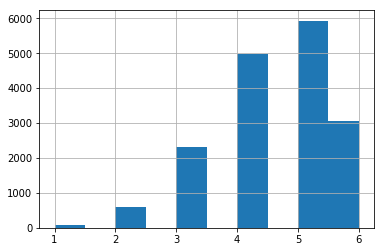

In [50]:
#group event=offer received per person in transactional records
print(transcript[transcript['event']=='offer received'].groupby('person')['event'].count().head())

#visualise offers received per person
transcript[transcript['event']=='offer received'].groupby('person')['event'].count().hist()

We can see above that the offer received per person in the transactional data could range from 1 to 6 offers received. I had the hypothesis that the frequency of offers received per person might result in more effective offers, so decided to engineer a feature `offer_received_cnt` to account for this frequency.

In [51]:
#get count of offers received per person, put into separate dataset
df_offer_received_cnt=transcript[transcript['event']=='offer received'].groupby(['person','offer_id','time']).count()['event'].reset_index()

#rename columns
df_offer_received_cnt.rename(columns={'event':'offer_received_cnt'},inplace=True)

#drop unnecessary columns
drop_cols('time',df_offer_received_cnt,inplace=True)

#ensure only unique person-offer_id pairs
df_offer_received_cnt=df_offer_received_cnt.groupby(['person','offer_id']).sum().reset_index()

#### d.ii. Separating user behaviours by transactions

I also wondered how many transactions were considered 'invalid' by my definition. Ordinarily, these would be the sum of transactions done by people not in group 1. The objective of offers are to drive purchases, so it would already be the case that users with high spend in their transactions would be flagged as `effective_offers`. 

We've already defined that there are people in groups 3 and 4, where they are separate pools of users who are loyal spenders, and already tend to purchase more, isolated from the the effect of offers. 

But for users in group 1 have a high amount of 'invalid spend' outside of the effect of offers, there might be some predictive power onto the effectiveness of offers; since a loyal user might have a higher tendency of taking up an offer.

In my datasets, I had already separated the transactions who are conversions versus transactions who are just the users' normal purchasing behaviour. This is through the `valid_completed` column, where I checked if a transaction had an `offer viewed` event prior. 

In the cases where `valid_completed`=1, I had already included them in my effective offers flag for BOGO and Discount offers. However, for those transctions where `valid_completed`=0, I have not considered them, and this could be a potential feature to include, as a proxy for the 'baseline' level of spending for a user.

The logic is to wonder if there is some baseline level of spending for users who are highly influenced by certain offers (in group 1), and group 2, and if there is some predictive power in this baseline level of 'invalid transactions' that can predict the propensity of a user to take up an offer.

In [52]:
#filter dataset by invalid transactions
df_transactions_invalid=transcript[(transcript['event']=='transaction') & (transcript['valid_completed']==0)].groupby(['person','offer_id'])['amount'].sum().reset_index()
df_transactions_invalid.rename(columns={'amount':'amount_invalid'},inplace=True)

#### d. iii. Time elapsed between offers received

I also wanted to include time as a potential feature into my dataset, but since the transactional data starts from time=0, I suspected it would not have been of much predictive power without some feature engineering. I had the hypothesis that if there were multiple offers received per person within a certain time period, there might be some predictive power in the time elapsed between offers received. 

In [53]:
#convert time into days
transcript['day_offer']=transcript['time']/24
#drop unnecessary columns
drop_cols(['time'],transcript,inplace=True);

#find time elapsed between offers received
transcript['time_elapsed_offers']=transcript[transcript['event']=='offer received'].groupby(['person','offer_id'])['day_offer'].diff()

#fill missing values with 0, as if someone does not receive an offer or is receiving an offer for the first time, there is no time elapsed
transcript['time_elapsed_offers']=transcript['time_elapsed_offers'].fillna(value=0)

#create temporary dataset
df_time_elapsed=transcript.groupby(['person','offer_id'])['time_elapsed_offers'].sum().reset_index()

### f. Preparing data for implementation

Now we can finally begin with preparing the data for modeling. 

To do this, there are some additional preparation steps for each dataset. Recalling our initial preliminary data exploration, there are some steps to prepare the data:

a. Merge with temporary datasets created above to include engineered features

b. Drop missing values in `gender` column for demographic data; convert gender into dummy variables

c. Separate the `channel` column into categorical variables

d. Treatment of duplicate records

#### f. ii.a. Merge with temporary datasets created above to include engineered features

In [54]:
#merge to get offers received count and invalid amount transacted 
offers_bogo=offers_bogo.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
offers_bogo=offers_bogo.merge(df_transactions_invalid[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

#### f.ii.b. Drop missing values in gender column for demographic data

Now, we need to check whether dropping the missing values will result in a significant loss in data.

In [55]:
#check % of missing values in dataset
(offers_bogo.isnull().sum()/len(offers_bogo)*100).sort_values(ascending=False).head()

amount_invalid            96.323752
income                     7.057489
gender                     7.057489
offer_received_cnt         0.000000
membership_tenure_days     0.000000
dtype: float64

We can see that the missing values are quite extensive especially for the `amount_invalid` column. It is debatable whether this column `amount_invalid` would be useful to include in the model. Since it is so 'sparse' for BOGO offers, it might not have much information after all. I plan to assess this feature again later during the model implementation phase. For now, I decided to fill the missing `amount_invalid` column with 0 as it could represent that only 3% of the overall users tend to purchase without offers; the other 97% would only purchase with awareness of an ongoing offer. 

Meanwhile, we had already conducted the analysis above on the `income` and  `gender` columns, which I choose to drop as they are not useful when they are null.

In [56]:
#fill missing values for amount_invalid with 0
offers_bogo['amount_invalid']=offers_bogo['amount_invalid'].fillna(value=0)

#drop income and gender null rows
offers_bogo.dropna(inplace=True);

#### f.ii.c. Separate the channel column into categorical variables



In [57]:
#foresee need to reuse function so create rename function
def rename(col_name,df):
    df[col_name]=np.where(df[col_name]==col_name,1,0)
    return df

#foresee need to reuse dummy variable encoding function
def dummy(df,col):
    df=pd.concat([df[:],pd.get_dummies(df[col],prefix=col)],axis=1)
    df=drop_cols(col,df)
    return df

In [58]:
#merge with portfolio to get offer details
offers_bogo=offers_bogo.merge(portfolio,how='left',on='offer_id')

#convert channels into categorical variables
channels = offers_bogo['channels'].apply(pd.Series)
channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})
offers_bogo=pd.concat([offers_bogo[:], channels[:]], axis=1)
rename('web',offers_bogo)
rename('email',offers_bogo)
rename('mobile',offers_bogo)
rename('social',offers_bogo)
offers_bogo=drop_cols('channels',offers_bogo)

#convert gender into categorical variables
offers_bogo=dummy(offers_bogo,'gender')

Since we need to repeat these steps for `offers_discount`, I created a function containing all the steps above.

In [59]:
def prep_offers_df(df):
    
    '''
    inputs:
    - df: original dataframe for modeling 
    
    outputs:
    - Returns dataframe containing engineered features, filled missing values and cleaned and transformed variables (channel and gender)
       
    '''
    #merge to get engineered features 
    df=df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
    df=df.merge(df_transactions_invalid[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])
    
    #fill missing values for amount_invalid with 0
    df['amount_invalid']=df['amount_invalid'].fillna(value=0)
    
    #drop income and gender null rows
    df.dropna(inplace=True);
    
    #merge with portfolio to get offer details
    df=df.merge(portfolio,how='left',on='offer_id')

    #convert channels into categorical variables
    channels = df['channels'].apply(pd.Series)
    channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})
    df=pd.concat([df[:], channels[:]], axis=1)
    rename('web',df)
    rename('email',df)
    rename('mobile',df)
    rename('social',df)
    df=drop_cols('channels',df)
    
    #convert gender column into dummy variables
    df=dummy(df,'gender')

    return df

In [60]:
#prepare data for offer_discounts
offers_discount=prep_offers_df(offers_discount)

For `offers_info` dataset, a slightly different treatment needs to be done as the `channels` column contains a different order of values.

In [61]:
#merge with portfolio to get offer details
offers_info=offers_info.merge(portfolio,how='left',on='offer_id')

#reset index for offers_info
offers_info=drop_cols('index',offers_info.reset_index())

#expand channel column into categorical variables
def channel_col(name,df=offers_info):
    '''
    inputs:
    - name: name of channel column to be transformed 
    - df: dataframe 
    
    outputs:
    - offer_info dataframe with channel column transformed
    
    '''
    df[name]= np.nan
    df.loc[pd.Series([name in df['channels'][x] for x in range(len(df['channels']))]),name]=1
    df[name]=df[name].fillna(value=0)
    return df

In [62]:
channel_col('web')
channel_col('email')
channel_col('mobile')
channel_col('social');

drop_cols('channels',offers_info,inplace=True);

In [63]:
#repurpose function for offers_info
def prep_offers_df(df):
    '''
    inputs:
    - df: dataframe to be transformed 
    
    outputs:
    - Returns dataframe with engineered features and filled missing values, with transformed gender column.
       
    '''
    #merge to get engineered features 
    df=df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
    df=df.merge(df_transactions_invalid[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

    #fill missing values for amount_invalid and offer_received_cnt with 0
    df['amount_invalid']=df['amount_invalid'].fillna(value=0)

    #drop income and gender null rows
    df.dropna(inplace=True);
    
    #convert gender column into dummy variables
    df=dummy(df,'gender')
    return df

In [64]:
offers_info=prep_offers_df(offers_info)

In [65]:
offers_info.head()

,person,offer_id,effective_offer,age,income,membership_tenure_days,difficulty,duration,offer_type,reward,web,email,mobile,social,offer_received_cnt,amount_invalid,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33,72000.0,506.0,0,4,informational,0,1.0,1.0,1.0,0.0,1.0,0.00,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33,72000.0,506.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,0.00,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,59,90000.0,824.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,0.00,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,24,60000.0,771.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,16.27,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26,73000.0,566.0,0,4,informational,0,1.0,1.0,1.0,0.0,1.0,0.00,1,0,0


#### f.i. Treatment of duplicate records

Since we have subset the data cleanly according to unique person-offer_id pairs by group, we should not have any duplicate records. But just in case, we check to make sure we have no duplicate records.

In [66]:
#check multiple records for each person and offer ids for the target variable
print((offers_bogo.groupby(['person','offer_id','effective_offer']).size()>1).sum())
print((offers_discount.groupby(['person','offer_id','effective_offer']).size()>1).sum())
print((offers_info.groupby(['person','offer_id','effective_offer']).size()>1).sum())

0
0
0


## Implementation

Now that the datasets are ready, we can proceed to implementing the model. Revisiting our objective, we wanted to analyse the drivers of an effective offer, with the target variable being `effective_offer`.

Since we have 3 offer types, there are thus 3 different models to be built. Since we are predicting whether an offer would be effective or not, this is effectively a binary classification supervised learning model.

I decided to compare the performance of a simple decision tree classifier model as a baseline model, with an ensemble random forest classifier model. Reason why I selected a decision tree as the baseline model is because I wanted to prioritise the interpretability of the model. Going back to the objective, since we intend to analyse the feature importance to determine the drivers of an effective offer, a decision tree would provide good interpretability for us to analyse.

Meanwhile, I also selected random forest as an alternate model to compare the baseline model is as an improvement over simple ensemble bagging of decision trees, in order to drive towards a high accuracy in training the model. 

Before we can proceed, we have to make sure that the classes we are predicting for are balanced in each dataset.

In [67]:
#check for class balance in datasets
print(offers_bogo[['person','effective_offer']].groupby('effective_offer').count()/len(offers_bogo))
print(offers_discount[['person','effective_offer']].groupby('effective_offer').count()/len(offers_discount))
print((offers_info[['person','effective_offer']].groupby('effective_offer').count()/len(offers_info)))

                  person
effective_offer         
0                0.17783
1                0.82217
                   person
effective_offer          
0                0.135256
1                0.864744
                 person
effective_offer        
0                0.2611
1                0.7389


We can see that the classes are quite uneven for all three offer types, but not too imbalanced such that it would pose a problem. Hence, we can proceed to implement the models.

A note on model evaluation and validation; since the classes for the all 3 models are imbalanced, I decided to implement both accuracy and f1 score as the model evaluation metric. F1 score provides a better sense of model performance compared to purely accuracy as takes both false positives and false negatives in the calculation. With an uneven class distribution, F1 may usually be more useful than accuracy. 

It is worth noting in this case that the F1 score is based on the harmonic mean of precision and recall, and focuses on positive cases. For the Starbucks app here, it would be fine as we would prioritise more on whether offers are effective, and less focus on why offers are ineffective.

### a. Model Implementation

Revisiting our objective, we are creating 3 models to predict the effectiveness of an offer within each type, depending on offer attributes and user demographics.

First, we have to define our target and features variables.

In [68]:
def data_prep(df,drop_cols_prep):
    '''
    inputs:
    - df: prepared dataframe for modeling 
    
    outputs:
    - Returns 2 dataframes - features and target dataframes
    '''
    # Split the data into features and target label
    target = df['effective_offer']
    features = drop_cols(drop_cols_prep,df)
    return features,target

Next, I split the data into training and test sets. Since the features of my data are all on different scales, I also apply a scaler to ensure my data will all be on the same scale for training. 

In [69]:
#prepare model pipeline
def model_pipeline(features,target):
    '''
    inputs:
    - features & target dataframe 
    
    outputs:
    - Splits features and target dataframe to train and test sets, performs feature scaling on both datasets.
    - Outputs X_train, X_test, y_train and y_test dataframes
    '''
    
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, 
                                                        test_size=0.20, 
                                                        random_state=42)

    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale test data
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

I am defining the functions here to run my model as I plan to implement 3 different models; hence it would be easier to implement repeatedly. In this function, I define the model scores - F1 score and accuracy, as well as the error (mean squared error). As elaborated above, I plan to compare the F1 score with the accuracy score as a better indication of model performance, especially since the classes for the BOGO and discount offers are uneven.

In [70]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the learner to the training data and get training time
    start = time() 
    learner = learner.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    start = time() 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #add training accuracy to results
    results['training_score']=learner.score(X_train,y_train)
    
    #add testing accuracy to results
    results['testing_score']=learner.score(X_test,y_test)
     
    print("{} trained on {} samples.".format(learner.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    print(classification_report(y_test, predictions_test,digits=4))
    return results

In [71]:
def run_model(clf1,clf2,name):
    '''
    inputs:
    - clf1: first classifier model
    - clf2: 2nd classifier model for comparison
    - name: name of models for comparison
    
    outputs:
    - Dataframe of results from model training and prediction
    '''
    
    # Collect results on the learners
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' +name
        results[clf_name] = {}
        results[clf_name]= train_predict(clf, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

#### a.i. BOGO offers model

First we try to build the BOGO offers model. I initialize the models with some randomly chosen parameters to check the initial performance. If performance needs to be improved further, I will attempt Grid Search to find the optimal parameters.

In [72]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model - baseline is DT model, bogo_1 model is RF model
baseline = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2,min_samples_split=90,min_samples_leaf=50)
bogo_1 = RandomForestClassifier(random_state=2,max_depth= 11, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=20)

results=run_model(baseline,bogo_1,'bogo_1')

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1770
MSE_test: 0.1823
Training accuracy:0.8230
Test accuracy:0.8177
             precision    recall  f1-score   support

          0     0.4797    0.2694    0.3450       438
          1     0.8553    0.9366    0.8941      2020

avg / total     0.7884    0.8177    0.7963      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1670
MSE_test: 0.1786
Training accuracy:0.8330
Test accuracy:0.8214
             precision    recall  f1-score   support

          0     0.4906    0.0594    0.1059       438
          1     0.8287    0.9866    0.9008      2020

avg / total     0.7684    0.8214    0.7591      2458



The accuracy for Random Forest Classifier (RF) model actually ends up outperforming the Decision Tree Classifier (DT) model slightly, but overall the performance for both models is about the same (82.14% vs 81.77% respectively in terms of accuracy). 
Accuracy for a first attempt is quite good, more than 80%. I will try to tune the model further to get a better accuracy.

However, in terms of the F1 score, both models are below 80%, with the Random Forest model performing worse compared to the Decision Tree Classifier, with 75.91% vs. 79.63%. To analyse this, we have to refer to the formula for Precision, Recall and F1 score:

**Recall or Sensitivity or TPR (True Positive Rate):** 

According to sklearn documentation, the recall is intuitively the ability of the classifier to find all the positive samples.

Number of items correctly identified as positive out of total true positives: True Positives /(True Positives +False Negatives)

**Precision:** 

According to the sklearn documentation, it is intuitively the ability of the classifier not to label as positive a sample that is negative.

Number of items correctly identified as positive out of total items identified as positive: True Positives /(True Positives + False Positives)


**F1 Score:** 

Since my F-beta score is F1 with beta=1, I am weighting recall and precision as equally important.

The formula is given by the harmonic mean of precision and recall:  F1 = 2*Precision*Recall/(Precision + Recall)

We can see that the F1 scores for DT outperformed RF slightly, but both are lower than the accuracy. This would indicate that DT model is doing slightly better compared to RF at not misclassifying negative events as positive (meaning, misclassifying people on which offers are ineffective, as people on which offers would be effective).  

The difference in F1 score vs accuracy indicate that there could are instances where both models are falsely classifying negatives as positives, likely due to the imbalance of classes. But the overall higher recall/accuracy compared to F1 score indicates that the model is predicting the positive case (i.e. where an offer is effective) more accurately compared to predicting the negative cases (i.e. where an offer is ineffective), which is expected given the uneven classes..

However, revisiting our use case, we are perhaps not as concerned with these misclassification since we don't mind sending people more offers than they would have liked; we would rather not miss anyone on which an offer would have been effective.

Given this case, I will still go with the RF model.

Since I aim to analyse the drivers of an effective offer, I will check the feature importances for the models after I have selected the best model from refinement.

#### a.ii. Discount offers model

I repeat the same steps above but with my offer_discounts dataset.

In [73]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_1 = RandomForestClassifier(random_state=2,max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)
results=pd.concat([results[:],run_model(baseline,discount_1,'discount_1')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



C:\Users\kaisyuenl\AppData\Local\Continuum\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1313
MSE_test: 0.1277
Training accuracy:0.8687
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.5000    0.0062    0.0122       325
          1     0.8729    0.9991    0.9317      2220

avg / total     0.8253    0.8723    0.8143      2545



This time, the Random Forest Classifier model also has a better performance compared to the Decision Tree Classifier in terms of accuracy (87.23% vs 86.72%), and the F1 score is also lower (81.43% vs 82.87%). 

The F1 score for these models are lower overall compared to the Accuracy score. This could be an indication that there are some instances where both models are classifying the negative cases (effective_offer = 0) falsely. Again, I am not too bothered by this as I am more concerned with the model predicting positive cases accurately, so would rather go with a higher accuracy model where F1 score for cases `effective_offer=1` is higher, for which our RF classifier has better performance (0.9317 vs 0.9280).

#### a.iii.  Informational offers model

In [74]:
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_1 = RandomForestClassifier(random_state=5,criterion='gini',max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)

results=pd.concat([results[:],run_model(baseline,info_1,'info_1')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2462
MSE_test: 0.2541
Training accuracy:0.7538
Test accuracy:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2367
MSE_test: 0.2491
Training accuracy:0.7633
Test accuracy:0.7509
             precision    recall  f1-score   support

          0     0.5636    0.0873    0.1512       355
          1     0.7586    0.9770    0.8540      1042

avg / total     0.7090    0.7509    0.6754      1397



The performance for these models are worse compared to the other 2 datasets, with accuracy below 80% for both models, but RF model still performing better. The F1 score is also worse, at 67.54% RF Classifier, worse than the DT model at 68.66%.

One potential reason for the worse performance is perhaps due to the fact that I had the key assumption to assign the conversion events to be transactions that only occur after an offer is viewed and within the specified duration; I might have missed out on some valuable information by removing those transactions that occur regardless. We can see this from how the overall sample dataset is smaller (about half) the datasets for the other 2 offers, with only about 5K samples compared to about 10K for both BOGO and discount respectively. 

### b. Refinement

In refining the model, I will first try parameter tuning for the 3 RF models, before expreimenting with removing or adding features to improve model performance. 

Since I will be comparing the models based on testing score repeatedly, I built a function to find the best RF model results based on refinement depending on offer type.

In [75]:
#define function to find best model results for each offer type
def best_model(offer_type):
    '''
    input:
    - offer_type: string of offer type name
    output:
    - dataframe containing results of best model so far
    
    '''
    print('For ' + offer_type + ' RF model:')
    return results.transpose()[results.transpose()['testing_score']==results.transpose()[results.transpose().index.str.contains("RandomForestClassifier_"+offer_type)]['testing_score'].max()]

#### b. i. Grid Search to discover optimal parameters
I decided to do GridSearch to determine what would be the optimal parameters for the model.

For all three offers, the Random Forest model had relatively good performance, so I used Grid Search on this to determine the best parameters.

In [76]:
#define Grid Search function
def rand_forest_param_selection(X,y):
    '''
    input:
    - X,y: training datasets for X and y
    output:
    - dictionary with best parameters for random forest model
    '''
    
    param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [5,10,15,20],
                'n_estimators': [10,20,25,30,40,50],
                'min_samples_split': [2, 10, 20],
                'min_samples_leaf': [2, 10,15, 20],
                }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [307]:
#define BOGO dataset
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#run Grid Search - commented out because takes to long to run, but have put in selected params in model
# rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 20,
 'n_estimators': 30}

Now that we have the optimal parameters for the BOGO model, I run my model again with the new parameters, keeping the DecisionTree baseline model with the same parameters as comparison.

In [77]:
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
bogo_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_2,'bogo_2')],axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1770
MSE_test: 0.1823
Training accuracy:0.8230
Test accuracy:0.8177
             precision    recall  f1-score   support

          0     0.4797    0.2694    0.3450       438
          1     0.8553    0.9366    0.8941      2020

avg / total     0.7884    0.8177    0.7963      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1562
MSE_test: 0.1749
Training accuracy:0.8438
Test accuracy:0.8251
             precision    recall  f1-score   support

          0     0.5408    0.1210    0.1978       438
          1     0.8369    0.9777    0.9018      2020

avg / total     0.7841    0.8251    0.7764      2458



In [78]:
results[['RandomForestClassifier_bogo_1','RandomForestClassifier_bogo_2']]

,RandomForestClassifier_bogo_1,RandomForestClassifier_bogo_2
pred_time,0.031262,0.071052
testing_score,0.821400,0.825061
train_time,0.109375,0.223444
training_score,0.833045,0.843829


In [79]:
#find best model so far for BOGO offer type
best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_2,0.071052,0.825061,0.223444,0.843829


The accuracy for the RF model increased slightly - from 82.14% to 82.51%, and the F1 score increased from 75.91% to 77.64%. This is a good performance increase but minimal, which indicates that perhaps there's not much that can be done to improve the performance of the model with parameter tuning. 

So I will have to explore other avenues with the features to improve the performance of the model further.

In [312]:
#define discount dataset
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

# run Grid Search - commented out because takes to long to run, but have put in selected params in model
# rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 20,
 'n_estimators': 30}

In [80]:
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_2,'discount_2')],axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1770
MSE_test: 0.1823
Training accuracy:0.8230
Test accuracy:0.8177
             precision    recall  f1-score   support

          0     0.4797    0.2694    0.3450       438
          1     0.8553    0.9366    0.8941      2020

avg / total     0.7884    0.8177    0.7963      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1562
MSE_test: 0.1749
Training accuracy:0.8438
Test accuracy:0.8251
             precision    recall  f1-score   support

          0     0.5408    0.1210    0.1978       438
          1     0.8369    0.9777    0.9018      2020

avg / total     0.7841    0.8251    0.7764      2458



In [81]:
results[['RandomForestClassifier_discount_1','RandomForestClassifier_discount_2']]

,RandomForestClassifier_discount_1,RandomForestClassifier_discount_2
pred_time,0.055039,0.043310
testing_score,0.872299,0.825061
train_time,0.163988,0.208162
training_score,0.868749,0.843829


In [82]:
#find best model so far for discount offer type
best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
DecisionTreeClassifier_discount_1,0.002002,0.872299,0.016012,0.862855
RandomForestClassifier_discount_1,0.055039,0.872299,0.163988,0.868749


The accuracy of the model increaased slightly, from 87.23% to 87.47%, and the F1 score improved from 81.43% to 82.06%. The good thing is that now both the accuracy and the F1 score for the RF model is better than the DT model. 

But because the increase was minimal, again we can conclude that tuning the parameters won't really improve the performance of the model significantly.

In [314]:
#define info dataset
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#run Grid Search - commented out because takes to long to run, but have put in selected params in model
# rand_forest_param_selection(X_train, y_train)

{'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 2,
 'n_estimators': 20}

In [83]:
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_2 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=20,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,info_2,'info_2')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2462
MSE_test: 0.2541
Training accuracy:0.7538
Test accuracy:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2405
MSE_test: 0.2470
Training accuracy:0.7595
Test accuracy:0.7530
             precision    recall  f1-score   support

          0     0.5926    0.0901    0.1565       355
          1     0.7595    0.9789    0.8553      1042

avg / total     0.7171    0.7530    0.6778      1397



In [84]:
results[['RandomForestClassifier_info_1','RandomForestClassifier_info_2']]

,RandomForestClassifier_info_1,RandomForestClassifier_info_2
pred_time,0.009291,0.018027
testing_score,0.750895,0.753042
train_time,0.106087,0.060833
training_score,0.763295,0.759534


In [85]:
#find best model so far for info offer type
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.018027,0.753042,0.060833,0.759534


Again we see some improvement in accuracy for RF model, from 75.09% to 75.30%, and slight increase in F1 score from 67.54% to 67.78%. This improvement is minimal,so we look into improving the feature selection of the model. 

#### b.ii Removing sparse features e.g. amount_invalid

In terms of feature selection, I wanted to try and see if removing the amount_invalid variable, which we had noted as being sparse, hence may not be useful in predicting the effectiveness of offers, would help.

I removed the feature from my data prep and retrained the model using the same optimal parameters found via GridSearch, with the DT model as a baseline.

In [86]:
#add amount_invalid variable to drop_cols_prep list
drop_cols_prep=['person','offer_id','effective_offer','offer_type','amount_invalid']

#train BOGO model
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
bogo_3 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_3,'bogo_3')],axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1743
MSE_test: 0.1810
Training accuracy:0.8257
Test accuracy:0.8190
             precision    recall  f1-score   support

          0     0.4759    0.1575    0.2367       438
          1     0.8405    0.9624    0.8973      2020

avg / total     0.7755    0.8190    0.7796      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1531
MSE_test: 0.1717
Training accuracy:0.8469
Test accuracy:0.8283
             precision    recall  f1-score   support

          0     0.5889    0.1210    0.2008       438
          1     0.8374    0.9817    0.9038      2020

avg / total     0.7931    0.8283    0.7785      2458



In [87]:
results[['RandomForestClassifier_bogo_2','RandomForestClassifier_bogo_3']]

,RandomForestClassifier_bogo_2,RandomForestClassifier_bogo_3
pred_time,0.071052,0.062512
testing_score,0.825061,0.828316
train_time,0.223444,0.181771
training_score,0.843829,0.846882


In [88]:
#find best model so far for BOGO offer type
best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_3,0.062512,0.828316,0.181771,0.846882


Model accuracy and F1 score did improve, so I will leave the amount_invalid feature out of my model.

In [89]:
#train discount model
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_3 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_3,'discount_3')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



C:\Users\kaisyuenl\AppData\Local\Continuum\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1310
MSE_test: 0.1265
Training accuracy:0.8690
Test accuracy:0.8735
             precision    recall  f1-score   support

          0     0.5882    0.0308    0.0585       325
          1     0.8754    0.9968    0.9322      2220

avg / total     0.8387    0.8735    0.8206      2545



In [90]:
results[['RandomForestClassifier_discount_2','RandomForestClassifier_discount_3']]

,RandomForestClassifier_discount_2,RandomForestClassifier_discount_3
pred_time,0.043310,0.058087
testing_score,0.825061,0.873477
train_time,0.208162,0.191597
training_score,0.843829,0.869044


In [91]:
#find best model so far for discount offer type
best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_3,0.058087,0.873477,0.191597,0.869044


Accuracy of the model actually increased while F1 model remained the same. In this case, I will also remove the amount_invalid feature for the discount model.

In [92]:
#train info model
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_3 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=20,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,info_3,'info_3')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2462
MSE_test: 0.2541
Training accuracy:0.7538
Test accuracy:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2365
MSE_test: 0.2520
Training accuracy:0.7635
Test accuracy:0.7480
             precision    recall  f1-score   support

          0     0.5263    0.0845    0.1456       355
          1     0.7575    0.9741    0.8522      1042

avg / total     0.6987    0.7480    0.6727      1397



In [93]:
results[['RandomForestClassifier_info_2','RandomForestClassifier_info_3']]

,RandomForestClassifier_info_2,RandomForestClassifier_info_3
pred_time,0.018027,0.027020
testing_score,0.753042,0.748031
train_time,0.060833,0.093057
training_score,0.759534,0.763474


In [94]:
#find best model so far for info offer type
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.018027,0.753042,0.060833,0.759534


Accuracy and F1 score of the model actually decreased here for info model, so I will also keep the feature in. This is expected since the model had already a worse performance compared to the other 2 models, so the model is slightly underfitting compared to the others. Hence the model needs more features to learn to predict better.

#### b. iii. Dropping one level of dummy variables/one-hot encoding

There is a debate when using tree models and using regression models when it comes to one hot encoding. For regression classification models (e.g. logistic regression, we should typically remove one level of the variable in order to prevent multicollinearity between variables. Typically, we should not run into this issue with tree-based models like the ones I am using here. 

However, there is some debate as to whether one should do it or not. According to some articles (like here: https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/), it is generally not advisable to encode categorical variables as they would generate sparse matrices, resulting in:

1. The resulting sparsity virtually ensures that continuous variables are assigned higher feature importance.
2. A single level of a categorical variable must meet a very high bar in order to be selected for splitting early in the tree building. This can degrade predictive performance.

In scikitlearn implementations of RF and DT, one has to encode the variables. So I decided to test my model performance if I were to drop one level of my categorical variables (in my data - the channel variables and the gender variables), just to reduce the sparsity and noise in the data for my model.

In [95]:
#add one level of dummy variables to drop column 
drop_cols_prep=['person','offer_id','effective_offer','offer_type','amount_invalid','social','gender_O']
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model - reuse best performing model - 
bogo_4 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_4,'bogo_4')],axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1743
MSE_test: 0.1810
Training accuracy:0.8257
Test accuracy:0.8190
             precision    recall  f1-score   support

          0     0.4759    0.1575    0.2367       438
          1     0.8405    0.9624    0.8973      2020

avg / total     0.7755    0.8190    0.7796      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1478
MSE_test: 0.1749
Training accuracy:0.8522
Test accuracy:0.8251
             precision    recall  f1-score   support

          0     0.5392    0.1256    0.2037       438
          1     0.8374    0.9767    0.9017      2020

avg / total     0.7843    0.8251    0.7774      2458



In [96]:
results[['RandomForestClassifier_bogo_3','RandomForestClassifier_bogo_4']]

,RandomForestClassifier_bogo_3,RandomForestClassifier_bogo_4
pred_time,0.062512,0.066363
testing_score,0.828316,0.825061
train_time,0.181771,0.265191
training_score,0.846882,0.852172


In [97]:
#find best model so far for BOGO offer type
best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_3,0.062512,0.828316,0.181771,0.846882


Performance of this model was not as good as previous model - hence I will keep alll levels of variables in.

In [98]:
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model - reuse best performing model - 
discount_4 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_4,'discount_4')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



C:\Users\kaisyuenl\AppData\Local\Continuum\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1308
MSE_test: 0.1269
Training accuracy:0.8692
Test accuracy:0.8731
             precision    recall  f1-score   support

          0     0.5714    0.0246    0.0472       325
          1     0.8748    0.9973    0.9320      2220

avg / total     0.8360    0.8731    0.8190      2545



In [99]:
results[['RandomForestClassifier_discount_3','RandomForestClassifier_discount_4']]

,RandomForestClassifier_discount_3,RandomForestClassifier_discount_4
pred_time,0.058087,0.066960
testing_score,0.873477,0.873084
train_time,0.191597,0.329125
training_score,0.869044,0.869241


In [100]:
#find best model so far for discount offer type
best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_3,0.058087,0.873477,0.191597,0.869044


Again, accuracy of model was not as good, and minimal improvement. Hence I will keep all levels in.

In [101]:
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model - reuse best performing model - 
info_4 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=20,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,info_4,'info_4')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2462
MSE_test: 0.2541
Training accuracy:0.7538
Test accuracy:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2380
MSE_test: 0.2520
Training accuracy:0.7620
Test accuracy:0.7480
             precision    recall  f1-score   support

          0     0.5205    0.1070    0.1776       355
          1     0.7606    0.9664    0.8512      1042

avg / total     0.6996    0.7480    0.6800      1397



In [102]:
results[['RandomForestClassifier_info_3','RandomForestClassifier_info_4']]

,RandomForestClassifier_info_3,RandomForestClassifier_info_4
pred_time,0.027020,0.023014
testing_score,0.748031,0.748031
train_time,0.093057,0.069109
training_score,0.763474,0.762041


In [103]:
#find best model so far for info offer type
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.018027,0.753042,0.060833,0.759534


Overall, we have seen that there is not much improvement in model performance just by reducing one level of categorical features. I am quite satisfied with the performance of the BOGO and discount models, but want to explore if I can improve the performance of the info model.

#### b. iv. Using polynomial features

Since a low accuracy score for the info model is likely due to the model underfitting, I decided to attempt if transforming the features further might improve model performance.

I tweaked my model_pipeline function to include the polynomial features transformation to my features. 

In [104]:
#prepare model pipeline
def model_pipeline_poly(features,target,poly_feat=0):
    '''
    input:
    - features & target dataframes
    - poly_feat: number of degrees to transform polynomial features
    
    output:
    - X_train, X_test, y_train, y_test dataframes
    
    '''
    
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, 
                                                        test_size=0.20, 
                                                        random_state=42)
    #fit and transform training data
    poly = PolynomialFeatures(poly_feat)
    X_train_poly=poly.fit_transform(X_train)
    
    #transform test data
    X_test_poly=poly.transform(X_test)
    
    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train_poly)

    #scale test data
    X_test=scaler.transform(X_test_poly)
    return X_train,X_test,y_train, y_test

In [105]:
#keep amount_invalid in offers_info dataset
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline_poly(features,target,2)

#Initialize the model
info_5 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=20,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,info_5,'info_5')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2448
MSE_test: 0.2491
Training accuracy:0.7552
Test accuracy:0.7509
             precision    recall  f1-score   support

          0     0.5393    0.1352    0.2162       355
          1     0.7653    0.9607    0.8519      1042

avg / total     0.7079    0.7509    0.6904      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2249
MSE_test: 0.2534
Training accuracy:0.7751
Test accuracy:0.7466
             precision    recall  f1-score   support

          0     0.5054    0.1324    0.2098       355
          1     0.7638    0.9559    0.8491      1042

avg / total     0.6981    0.7466    0.6867      1397



In [106]:
results[['RandomForestClassifier_info_2','RandomForestClassifier_info_5']]

,RandomForestClassifier_info_2,RandomForestClassifier_info_5
pred_time,0.018027,0.015642
testing_score,0.753042,0.746600
train_time,0.060833,0.151062
training_score,0.759534,0.775112


In [107]:
#find best model so far for info offer type
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.018027,0.753042,0.060833,0.759534


We can see that performance actually decreased slightly for the RF model. Hence it would perhaps be a better idea to just keep the model as is. A maximum accuracy of 75.30% is acceptable for the info offers, even though it is not as high as the BOGO or discount offers. After all, we already included some assumptions for the 'influence' of the offer based on the duration.

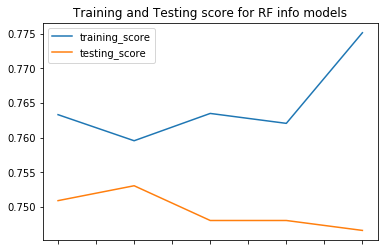

In [108]:
results.loc[['training_score','testing_score'],['RandomForestClassifier_info_1','RandomForestClassifier_info_2','RandomForestClassifier_info_3','RandomForestClassifier_info_4','RandomForestClassifier_info_5']].transpose().plot.line()
plt.title('Training and Testing score for RF info models')
plt.show()

A note however, we can above actually see the model is performing better in the training accuracy as we add more variables for each model via polynomial features and removing the amount_invalid feature. It is just that the testing accuracy was reducing, and we can see this is due to overfitting.

I can improve the accuracy and performance of the info model further by using RF info model 5, but adding more data, as we already noted the dataset for the `offers_info` dataset is half the size of the BOGO and discount datasets. Hence, ultimately with more data and with performance tuning, removing unnecessary variables and feature transformation, with more data I could have ultimately got the performance of the model perhaps above 80%.

**b.iv. Discussion on best models and feature importances:**

Now that I am done with refining the 3 models, we can check the results for our best models for all 3 and check the feature importances to see the top drivers of effectiveness of offers.

In [121]:
#get best model overall for bogo,discount and info offers
best_model('bogo').append([best_model('discount'),best_model('info')]).transpose()

For bogo RF model:
For discount RF model:
For info RF model:


,RandomForestClassifier_bogo_3,RandomForestClassifier_discount_3,RandomForestClassifier_info_2
pred_time,0.062512,0.058087,0.018027
testing_score,0.828316,0.873477,0.753042
train_time,0.181771,0.191597,0.060833
training_score,0.846882,0.869044,0.759534


Overall, we can see that the top performing models are the 3rd model (with GridSearch to find optimal model parameters and removing amount_invalid column) for predicting effectiveness of BOGO and discount offers, whereas the best performing model for informational offers was just after performing GridSearch to find the optimal parameters.

In order to find the most influential drivers of an effective offer, we can check the feature importances of our best models above.

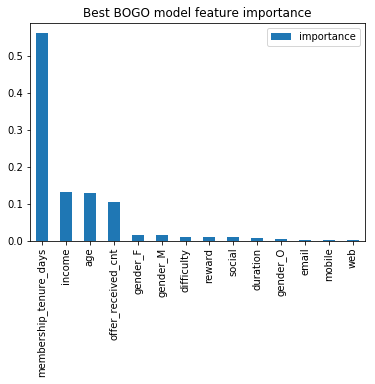

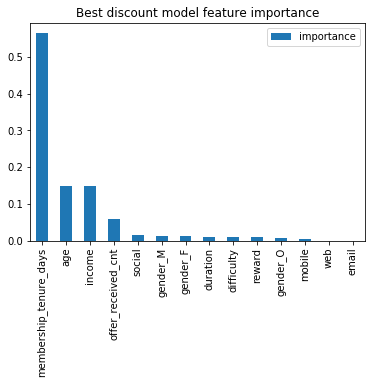

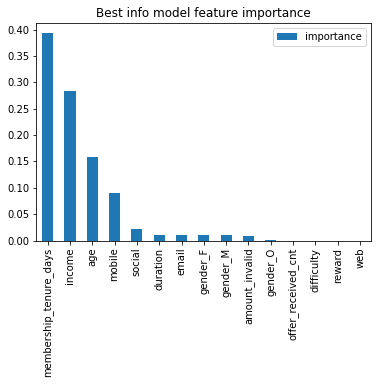

In [127]:
#show feature importance
#BOGO 3 model
#prepare data same as BOGO 3 state
drop_cols_prep=['person','offer_id','effective_offer','offer_type','amount_invalid']
features,target=data_prep(offers_bogo,drop_cols_prep)

feature_importances = pd.DataFrame(bogo_3.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best BOGO model feature importance')
plt.show()

#discount 3 model
feature_importances = pd.DataFrame(discount_3.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best discount model feature importance')
plt.show()

#info_2 model
#prepare data similar to info_2 state
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_discount,drop_cols_prep)
#print feature importance
feature_importances = pd.DataFrame(info_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best info model feature importance')
plt.show()

Checking on the feature importance to analyse the main drivers of an effective offer, we can see that the most important driver of effective offers across all three are the tenure of membership. However, the 2nd most important feature is different for each of the three models.

For a BOGO offer, the membership tenure is the most important feature, and the other variables are a lot smaller in proportions. Income, age and offer_received_cnt are the 2nd, 3rd and 4th most important features, but their proportions are very small.

For a discount offer, after the membership tenure, age and income are the next most important variables. But it is still very small in proportions.

The feature importances for the informational offer models are more distributed compared to the BOGO and discount models, with income being the 2nd most important feature. Age is the third and mobile channel interestingly being the 4th.

### c. Exploration on users in Groups 3 and 4 - People who purchase regardless of viewing any offers

We had earlier delineated those in groups 3 and 4 as people who would purchase regardless of viewing any offers. Now we can do some exploratory analyses to see what kind of demographic this group of users consist of.

**c.i. Data Preparation:**

It would be interesting to see how people in groups 3 and 4 contrast with people in groups 1 and 2, so I decided to compare between all 3.

First, I need to append the data from all groups from the three offer types together, then compare the characteristics of each group via visualizations.

In [109]:
#append datasets together

#grp 3+4
grp3_4=grp3_bogo.append(grp3_discount,sort=False)
grp3_4=grp3_4.append(grp3_info,sort=False)
grp3_4=grp3_4.append(grp4_bogo,sort=False)
grp3_4=grp3_4.append(grp4_discount,sort=False)
grp3_4=grp3_4.append(grp4_info,sort=False)

#grp1
grp1_all=grp1_bogo.append(grp1_discount,sort=False)
grp1_all=grp1_all.append(grp1_info,sort=False)

#grp2
grp2_all=grp2_bogo.append(grp2_discount,sort=False)
grp2_all=grp2_all.append(grp2_info,sort=False)

#get unique person-offer_id pairs
grp3_4=grp3_4[['person','offer_id']].groupby(['person','offer_id']).count().reset_index()
grp1_all=grp1_all[['person','offer_id']].groupby(['person','offer_id']).count().reset_index()
grp2_all=grp2_all[['person','offer_id']].groupby(['person','offer_id']).count().reset_index()

#get membership_tenure_days
grp3_4=member(grp3_4)
grp1_all=member(grp1_all)
grp2_all=member(grp2_all)

#merge with transcript to check transaction amount
grp3_4=grp3_4.merge(transcript[['person','offer_id','amount']].groupby(['person','offer_id']).sum(),on=['person','offer_id'],how='left')
grp1_all=grp1_all.merge(transcript[['person','offer_id','amount']].groupby(['person','offer_id']).sum(),on=['person','offer_id'],how='left')
grp2_all=grp2_all.merge(transcript[['person','offer_id','amount']].groupby(['person','offer_id']).sum(),on=['person','offer_id'],how='left')

We should also clean the dataset of null values, similar to the preparation of the datasets above for modeling.

In [110]:
#check null values
print("For grp 3 and 4:")
print((grp3_4.isnull().sum()/len(grp3_4))*100)

#drop null values
grp3_4=grp3_4.dropna()

#check null values
print("For grp 1:")
print((grp1_all.isnull().sum()/len(grp1_all))*100)

#drop null values
grp1_all=grp1_all.dropna()

#check null values
print("For grp 2:")
print((grp2_all.isnull().sum()/len(grp2_all))*100)

#drop null values
grp2_all=grp2_all.dropna()

For grp 3 and 4:
person                    0.000000
offer_id                  0.000000
age                       0.000000
gender                    9.019155
income                    9.019155
membership_tenure_days    0.000000
amount                    0.000000
dtype: float64
For grp 1:
person                    0.000000
offer_id                  0.000000
age                       0.000000
gender                    5.896762
income                    5.896762
membership_tenure_days    0.000000
amount                    0.000000
dtype: float64
For grp 2:
person                     0.000000
offer_id                   0.000000
age                        0.000000
gender                    21.131608
income                    21.131608
membership_tenure_days     0.000000
amount                     0.000000
dtype: float64


In [111]:
#check size of groups
print("Size of group 1: "+ str(len(grp1_all['person'])))
print("Size of group 3+4: "+ str(len(grp3_4['person'])))
print("Size of group 2: "+ str(len(grp2_all['person'])))

Size of group 1: 26507
Size of group 3+4: 18904
Size of group 2: 5729


Comparing the sizes of the 3 groups, we can see that group 1 is the largest, while group 2 is the smallest, which is unsurprising as we had seen that the classes in our datasets were imbalanced in favour of positive classes (i.e. `effective_offers=1`). Meanwhile for people in groups 3 and 4 there are quite a significant number of people as well, larger than the number of people in group 2.

**c.ii. Exploration of demographic characteristics:**

Meanwhile, in order to effectively compare between the groups, I created a function to efficiently visualize the groups together.

In [112]:
#create function for plotting multiple histograms overlaying the 3 groups
def plot_hist(variable,bins=None):
    plt.hist(grp1_all[variable],alpha=0.5, label='group 1',bins=bins)
    plt.hist(grp3_4[variable], alpha=0.5, label='group 3 and 4',bins=bins)
    plt.hist(grp2_all[variable], alpha=0.5, label='group 2',bins=bins)
    plt.legend(loc='upper right')
    plt.title('distribution of '+ variable + ' between group 1, group 2 and groups 3 + 4')
    plt.show()

First, we can explore the income distribution between the 3 groups.

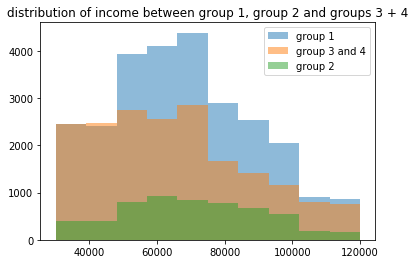

In [113]:
#plot distribution of income
plot_hist('income')

Across the 3 segments, most people fall within the middle range of income (50K - 100K). The income distribution between the 3 segments are relatively similar.

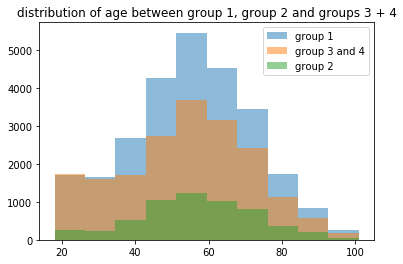

In [114]:
#plot ditribution of age
plot_hist('age')

Age distribution looks relatively similar between the 3 groups as well, with most people between the age 40-80 years old.

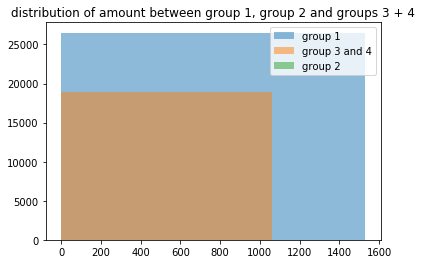

In [115]:
#plot distribution of amount spent given an effective offer
plot_hist('amount',bins=1)

Group 2 are people who did not spend at all as the offers were ineffective on them, hence they are not in the graph. But for groups 1 and 3+4, we can see that the amount spent is relatively similar, except that people in group 1 spent slightly more. This is to be expected as we might expect that the offers managed to incentivise them to purchase more, hence their overall spend increased. 

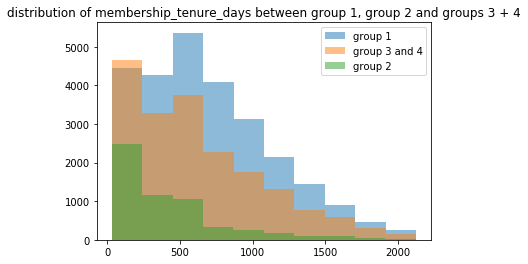

In [116]:
#plot tenure of membership
plot_hist('membership_tenure_days')

The distribution of membership tenure also looks similar between the 3 segments, with most people between 0-700 days of tenure. It appears as though there are not much demographic characteristic differences between the 3 groups, at least in the current data provided.

### d. Potential all-in-one model

Out of curiosity, I wondered if we could predict the effectiveness of an offer if the offer type was included as a categorical feature. Would the type of offer affect the user's responsiveness?

To do this, I would need to do some minor data preparation to prepare the data for a multiclass model.

In [117]:
#append datasets together
offers_bogo['offer_type']='bogo'
offers_info['offer_type']='informational'
offers_discount['offer_type']='discount'
offers=offers_discount.append(offers_bogo,sort=False)
offers=offers.append(offers_info,sort=False)

#create dummy variable for offer_type categorical variable
offers=dummy(offers,'offer_type')

In [653]:
#do grid search to find optimal parameters for RF model
drop_cols_prep=['person','offer_id','effective_offer','amount_invalid']
features,target=data_prep(offers,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

rand_forest_param_selection(X_train, y_train)

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 2,
 'n_estimators': 50}

In [118]:
drop_cols_prep=['person','offer_id','effective_offer','amount_invalid']
features,target=data_prep(offers,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
all_in_one = RandomForestClassifier(random_state=5,criterion='gini',max_depth= 20, max_features= 'auto',min_samples_split= 2,n_estimators=50,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,all_in_one,'all_in_one')],axis=1)

DecisionTreeClassifier trained on 25594 samples.
MSE_train: 0.1761
MSE_test: 0.1753
Training accuracy:0.8239
Test accuracy:0.8247
             precision    recall  f1-score   support

          0     0.5269    0.0778    0.1356      1131
          1     0.8326    0.9850    0.9024      5268

avg / total     0.7786    0.8247    0.7669      6399

RandomForestClassifier trained on 25594 samples.
MSE_train: 0.1638
MSE_test: 0.1749
Training accuracy:0.8362
Test accuracy:0.8251
             precision    recall  f1-score   support

          0     0.5316    0.0893    0.1529      1131
          1     0.8341    0.9831    0.9025      5268

avg / total     0.7806    0.8251    0.7700      6399



In [119]:
#comparing best performance of all 3 models with all_in_one model
results[['RandomForestClassifier_bogo_3','RandomForestClassifier_discount_3','RandomForestClassifier_info_2','DecisionTreeClassifier_all_in_one','RandomForestClassifier_all_in_one']]

,RandomForestClassifier_bogo_3,RandomForestClassifier_discount_3,RandomForestClassifier_info_2,DecisionTreeClassifier_all_in_one,RandomForestClassifier_all_in_one
pred_time,0.062512,0.058087,0.018027,0.000000,0.262158
testing_score,0.828316,0.873477,0.753042,0.824660,0.825129
train_time,0.181771,0.191597,0.060833,0.034128,0.838811
training_score,0.846882,0.869044,0.759534,0.823904,0.836212


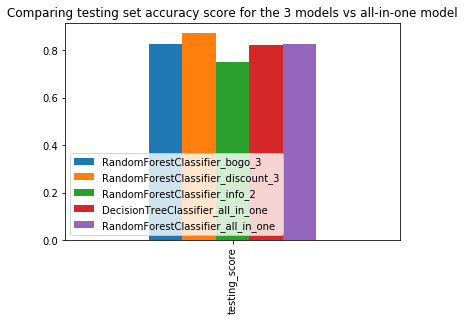

In [120]:
results.loc[['testing_score'],['RandomForestClassifier_bogo_3','RandomForestClassifier_discount_3','RandomForestClassifier_info_2','DecisionTreeClassifier_all_in_one','RandomForestClassifier_all_in_one']].plot.bar()
plt.title('Comparing testing set accuracy score for the 3 models vs all-in-one model')
plt.legend(loc=3)
plt.show()

Comparing the performance of the 3 best models for each offer type with the all_in_one model, we can se that having the all-in-one model is not as good as the RF bogo and discount models, and is about slightly better than the info model. This is probably due to the info model pulling down the performance, resulting in lower accuracy for the all in one model. I suspect that if we were to break down the all-in-one model performance to just looking at its ability to predict the effectiveness of informational offer types, it would also be worse than its performance predicting the other 2 types.  

If we take a step back and look at the big picture, it is more useful to have a higher accuracy for 3 separate models, as opposed to one all-in-one model. This is because the BOGO and discount offers are actually aimed at driving sales with some promotional cost, whereas the informational offer is essentially 'free' with no cost, and if they can drive sales that would be a bonus.

Hence, I would actually suggest that the 3 separate models are more useful.

### e. Given an effective offer, can we predict how much someone would spend? 

In addition to the all-in-one model, since we already kept the datasets of effective transactions, I was curious to know if I could build a regression model to predict how much someone would spend, given an effective offer. I could have built a model separately for each offer type to predict their spend, but I was curious to know if the type of offer would also determine a user's level of spend. 

To do this, we have already assigned effective offers based on group 1 customers. From there, we just need to sum up their amount of spend driven by offers to see if we can predict how much someone would spend depending on the offer type.

In [130]:
#append all 3 datasets together
grp1=grp1_bogo.append(grp1_discount,sort=False)
grp1=grp1.append(grp1_info,sort=False)

#drop unnecessary columns
drop_cols('effective_offer',grp1,inplace=True)

#get offer details
grp1=grp1.merge(portfolio,how='left',on='offer_id')

We only take into account transactions that are influenced by an offer (i.e. `valid_completed=1`) as we want to predict the spend given (i.e. based on) the influence of an effective offer.

In [131]:
#get sum of valid transactions per person based on unique person and offer_id pair
grp1=grp1.merge(transcript[['person','offer_id','amount']][transcript['valid_completed']==1].groupby(['person','offer_id']).sum(),on=['person','offer_id'])

In [132]:
#get demographic data and membership_tenure details
grp1=member(grp1)

#reset index for offers_info
grp1=drop_cols('index',grp1.reset_index())

#reuse offers_info channel_col function to expand channel column into categorical variables
channel_col('web',grp1)
channel_col('email',grp1)
channel_col('mobile',grp1)
channel_col('social',grp1);

drop_cols('channels',grp1,inplace=True);

#reuse offers_info function to prep dataset
grp1=prep_offers_df(grp1)

#encode offer type as dummy variables
grp1=dummy(grp1,'offer_type')

Since this is a regression model, we need to prevent multicollinearity by reducing the level of the dummy variables by 1, dropping those columns.

In [133]:
#add one level of dummy variable to drop
drop_cols_prep=['person', 'offer_id','amount','social','gender_O','offer_type_informational']
target=grp1['amount']
features=drop_cols(drop_cols_prep,grp1)

Since this is a regression model, we need to change the metrics such that it is not a classification model. Hence, I tweak my `train_predict` and `run_model` functions.

In [134]:
#tweak train_predict function -
def train_predict_reg(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the learner to the training data and get training time
    start = time() 
    learner = learner.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    start = time() 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #add training accuracy to results
    results['training_score']=learner.score(X_train,y_train)
    
    #add testing accuracy to results
    results['testing_score']=learner.score(X_test,y_test)
    
    print("{} trained on {} samples.".format(learner.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    return results

In [135]:
def run_model_reg(clf1,clf2,name):
    '''
    input:
    - clf1: baseline regression model
    - clf2: 2nd regression model to compare
    - name: name to keep track of comparison
    output:
    - dataframe containing results of training and prediction of model
    
    '''
    
    # Collect results on the learners
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' +name
        results[clf_name] = {}
        results[clf_name]= train_predict_reg(clf, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

In [136]:
X_train, X_test, y_train, y_test=model_pipeline_poly(features,target,2)

#Initialize the model
clf1 = Ridge(alpha=2,random_state=2)
clf2 = DecisionTreeRegressor(random_state=2)

results_reg=run_model_reg(clf1,clf2,'reg')

Ridge trained on 21011 samples.
MSE_train: 5149.4918
MSE_test: 5264.4857
Training accuracy:0.0901
Test accuracy:0.0863
DecisionTreeRegressor trained on 21011 samples.
MSE_train: 0.0410
MSE_test: 11106.1821
Training accuracy:1.0000
Test accuracy:-0.9277


In [137]:
results_reg

,Ridge_reg,DecisionTreeRegressor_reg
pred_time,0.009010,0.022016
testing_score,0.086260,-0.927664
train_time,0.709011,1.476255
training_score,0.090122,0.999993


The regression models really underperformed in terms of predicting the amount spent. It appears with the current data within our group 1 of customers, there is not enough information to predict the amount that can be driven by the offer type. We can see the Decision Tree Regressor model really overfit the data, with a very high training score but sub par testing score. Meanwhile, the linear regression model (with ridge/l2 regularization) also shows a minimal correlation between the features and the target variable. The model really underfits the data.

I may get better performance if I break the models up into 3 different models based on offer type again; or even try to include non-influenced/invalid transactions, but this could be an exploration for another time.

## Conclusion

Overall, I found this project challenging, mainly due to the structure of the data in the `transcript` dataset. I had started out with 2 business questions:

1. What are the main drivers of an effective offer on the Starbucks app?
2. Could the data provided, namely offer characteristics and user demographics, predict whether a user would take up an offer?

### a. Reflection:

#### a.i. Question 1 findings:
For Question 1, the feature importance given by all 3 models were that the tenure of a member is the biggest predictor of the effectiveness of an offer. Further study would be able to indicate what average tenure days would result in an effective BOGO offer. 

For all three models, the top 3 variables were the same - membership tenure, income and age. However, income and age switched orders depending on offer type. 

For BOGO and discount offers, the distribution of feature importances were relatively equal. However, for informational offers, the distribution is slightly more balanced, with income the second most important variable.

#### a.ii. Question 2 findings:

My decision to use 3 separate models to predict the effectiveness of each offer type ended up with good accuracy for the BOGO and discount models (82.83% for BOGO and 87.35% for discount), while slightly less accurate performance for informational offers (75.3%). However, I would regard 75% as acceptable in a business setting, as for informational offers, there is no cost involved to inform users of a product.

Meanwhile, for BOGO and discount models, I am quite happy with the 80% and above accuracy, as in a business setting that would be acceptable to show offers to people, even if the model misclassifies a few, the overall revenue increase might justify the few mistakes. 

### b. Main challenges and potential improvement:

When analysing and building the machine learning models to answer the above questions, reflections on my main challenges and findings are as follows:

#### b.i. Attribution framework for assigning offer_ids for transactions:

In order to answer Question 1, I had to first define what an 'effective offer' means using the transactional records. This proved to be the trickiest portion of the project. I had to define a funnel for what what an effective conversion would look like, as we had data on both effective and noneffective conversions. Thus, I was desigining an attribution model for the conversion events (`offer completed` and `transaction` events) based on the events that occurred prior for each person.

I ended up having to separate the users into 4 different pools, based on their actions in the transcript data:

- Group 1: People who are influenced by offers and thus purchase/complete the offer(successful/effective conversion of offer)
- Group 2: People who receive and an offer but is not influenced and thus no conversion event (ineffective conversion of offer)
- Group 3: People who have conversion events but was not actually influenced by an offer
- Group 4: People who receive offers but no views or action taken

Even after separating the groups, it was challenging to assign the people in group 3 based on the transactional data. I had to define the event space where the right sequence of events would occur before I could assign an offer id to transactions (which did not have an offer_id), essentally designing a event/sequence-based attribution window.

After attributing the conversions to specific offers, the rest of the data preparation and cleaning was relatively straightforward. I was grateful that there were not many missing values, and the preparation of categorical variables was also relatively straightforward.

#### b.ii. Feature engineering:

I decided to do some basic feature engineering as I found the model had slightly underfit on my first attempt in this project, so I had added the feature engineering section later. It improved the performance of the model slightly, and the membership_tenure feature I had engineered out of the `became_member_on` column ended up being the most important predictor variable.

However, overall I found that I could not think of additional features using the time data, even though I had the hunch that the time of receiving the offer might be quite influential in determining whether it is effective or not. 

#### b.iii. Model implementation decisions:

I had made the decision to build 3 separate models depending on offer types based on my definition of the problem statement - as I wanted to discover what would drive an effective offer, I thought it made more sense to remove noise from the data by separating the data into the offer types. My decision ended up to be quite a good one as the single BOGO and discount models got good performance in testing scores, compared to the all-in-one model overall score. 

For the info model, the accuracy was slightly worse as we had less records overall (half of the BOGO and discount models). As elaborated above, I believe that if we had more data, I could have gotten the accuracy higher, as there was a clear diverging pattern occurring between the training and testing score as I made decisions to improve the model fit like adding polynomial features and removing 'noisy' features like the amount_invalid feature. Due to the limited data, my decisions ended up with the model overfitting, hence I believe the model accuracy would have benefitted from more data.

An additional note on model selection - I selected tree-based models as I wanted to assess feature importance, but I could have extended this study further by testing a parametric/ regression model (e.g. logistic regression for classification tasks). The weights of the coefficients from a regression model might have been interesting to contrast with the feature importance of a tree-based model, given that both models have different ways of analysing the data. The feature `membership_tenure_days` might not have been the highest weighted feature, in contrast to how it was in this study.

#### b.iv. Exploring demographics of different customer groups:

I was curious to know what the characteristics were of groups 3 and 4, which are customers who are not influenced by an offer at all. However, after comparing their characteristics with groups 1 and 2, I could not see any significant differences in their demographics.

I would have liked to have more data to perhaps understand why this group of customers tend to not be influenced by offer, in order to make useful suggestions on how to give a good customer experience to these customers, even if we do not serve them any offers.

#### b.v. Model accuracy in predicting amount spent given an effective offer:

The regression model I built out of curiosity to see if we could predict the amount a user would spend, given that they are effectively influenced by an offer. The motivation was that if we can predict how much someone would spend given an offer, perhaps we can assess which offers bring in the most revenue. 

However, my model found virtually no correlation between the features provided (namely, offer characteristics and demographics of app users) with the amount spent per user. These features aren't strong enough to predict the amount spent per user. Perhaps if we also have a value of the offer, for example, for a discount offer, the value of the discount in dollar terms, perhaps we might be able to predict better.

Perhaps I could have broken them up into 3 different models for the 3 offer types, the way I did with the binary classification models, in order to get a better result. However, given that this was just a curiosity and I wanted to explore if the offer type would be a statistically significant predictor feature, I built an all-in-one model for this instance. This would be worth exploring further, given more time and data.